In [270]:
# Let's setup the imports we'll need first
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import esri2gpd
import carto2gpd
import seaborn as sns

In [271]:
import geopandas as gpd

# Read the shape file, giving the name of the directory
NPS = gpd.read_file("C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/NPS_-_National_Register_of_Historic_Places_Locations-shp/NPS_-_National_Register_of_Historic_Places_Locations.shp")

In [272]:
# Lets review all existing columns:
NPS.columns

Index(['OBJECTID', 'NRIS_Refnu', 'PROPERTY_I', 'RESNAME', 'ResType', 'Address',
       'City', 'County', 'State', 'Vicinity', 'MultiName', 'NumCBldg',
       'NumCObj', 'NumCSite', 'NumCStru', 'Status', 'Is_NHL', 'Status_Dat',
       'Listed_Dat', 'NARA_URL', 'BND_TYPE', 'BND_OTHER', 'IS_EXTANT',
       'EXTANT_OTH', 'CREATEDATE', 'EDIT_DATE', 'MAP_METHOD', 'MAP_MTH_OT',
       'SOURCE', 'SRC_DATE', 'SRC_SCALE', 'SRC_ACCU', 'SRC_COORD',
       'ORIGINATOR', 'CONSTRANT', 'CR_ID', 'GEOM_ID', 'geometry'],
      dtype='object')

In [273]:
# query the unique values of 'status' column:

NPS.Status.unique()

array(['Listed', 'Removed', None], dtype=object)

In [274]:
# how many from each one:

NPS['Status'].value_counts()

#there are 181 removed that we wish to drop from the dataset before starting. 
#We also wish to clean rows with no geometry (if there are)

Listed     56716
Removed      181
Name: Status, dtype: int64

In [275]:
len(NPS)

67443

In [276]:
NPS = NPS[NPS['Status']!='Removed']

len(NPS)

67262

In [277]:
# remove NaNs
NPS = NPS[NPS['geometry'].isna() != True]

len(NPS)

67244

In [278]:
NPS_grped = NPS.groupby('State').count().reset_index()

In [279]:
import cenpy
acs = cenpy.remote.APIConnection("ACSDT5Y2018")

#total population
#acs.varslike("B01003").sort_index().iloc[:15]

In [280]:
# education B29002

#acs.varslike("B29002").sort_index().iloc[:15]

In [281]:
# poverty B29003

#acs.varslike("B19001A_017E").sort_index().iloc[:15]

In [282]:
# Income B19001

#acs.varslike("B19001").sort_index().iloc[:15]

In [283]:
# Table B23025: Employment Status
# B23025_005E	Estimate!!Total!!In labor force!!Civilian labor force!!Unemployed
# B23025_001E	Estimate!!Total
# verify the right code is used

#acs.varslike("B23025_005E").sort_index().iloc[:15]

In [284]:
# Table B02008: White Alone or in Combination With One or More Other Races
# verify the right code is used

#acs.varslike("B02008").sort_index().iloc[:15]

In [285]:
variables = ["NAME", "B01003_001E","B02008_001E","B23025_005E","B23025_001E","B29002_001E","B29002_006E","B29002_007E",
             "B29002_008E","B29003_001E","B29003_002E","B19001A_001E","B19001A_016E","B19001A_017E"]

# Pull data by census tract
census_data = acs.query(
    cols=variables,
    geo_unit="state:*",
)

# Convert to the data to floats
for col in variables[1:]:
    census_data[col] = census_data[col].astype(int)

census_data.columns = ['NAME', 'POPULATION','WHITE','UNEMPLOYED','TOTAL_EMP',"edu_total","edu_1","edu_2","edu_3",
                       "pov_tot","pov_below","inc_tot","inc_high1","inc_high2",'state']

census_data.head()

,NAME,POPULATION,WHITE,UNEMPLOYED,TOTAL_EMP,edu_total,edu_1,edu_2,edu_3,pov_tot,pov_below,inc_tot,inc_high1,inc_high2,state
0,Minnesota,5527358,4749380,119218,4379008,4037295,449792,906921,427276,3940147,344323,1907876,143913,143086,27
1,Mississippi,2988762,1786914,110036,2350291,2228659,206747,279446,161062,2145906,384612,677533,30865,26200,28
2,Missouri,6090062,5151022,155958,4864065,4585994,351725,764086,434106,4437928,546197,2017917,101409,94795,29
3,Montana,1041732,953454,22433,838808,804263,67717,154949,73265,784859,100735,390495,17329,16291,30
4,Nebraska,1904760,1709927,36545,1483161,1358786,138686,272444,125607,1315343,128655,681092,36510,32127,31


In [286]:

census_data['white_per'] = census_data['WHITE'] / census_data['POPULATION'] *100

census_data['unemployed_per'] = census_data['UNEMPLOYED'] / census_data['TOTAL_EMP'] *100

census_data['edu_WithDegree_per'] = (census_data['edu_1'] + census_data['edu_2'] + census_data['edu_3']) / census_data['edu_total'] *100

census_data['BelowPoverty_per'] = census_data['pov_below'] / census_data['pov_tot'] *100

census_data['Above150_inc_per'] = (census_data['inc_high1'] + census_data['inc_high2']) / census_data['inc_tot'] *100

census_data = census_data[['NAME', 'POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per']]

census_data.head()

,NAME,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per
0,Minnesota,5527358,85.924957,2.722489,44.187730,8.738836,15.042854
1,Mississippi,2988762,59.787765,4.681803,29.042352,17.923059,8.422468
2,Missouri,6090062,84.580781,3.206331,33.796752,12.307478,9.723096
3,Montana,1041732,91.525843,2.674390,36.795302,12.834789,8.609585
4,Nebraska,1904760,89.771257,2.463994,39.501217,9.781099,10.077493


In [287]:
# now I wish to plot this table:

import hvplot
import hvplot.pandas 

df_head = census_data.head(n=10)
table = df_head.hvplot.table(sortable=True, selectable=True)
hvplot.save(table, "C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/table_variables.html")

In [288]:
#convert the name column to upper:

census_data['NAME'] = census_data['NAME'].str.upper() 

len(census_data)

52

In [289]:
NPS_census = census_data.merge(
    NPS_grped,
    left_on=["NAME"],
    right_on=["State"],
)

len(NPS_census)

52

In [290]:
#adding 2019 final quarter GDP (from table) to  create a chart:

# Load data 
GDP_2019 = pd.read_csv("C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/gdp2019_edited.csv")
GDP_2019['State'] = GDP_2019['State'].str.upper() 
GDP_2019 = GDP_2019.dropna()

In [291]:
GDP_2019.State = GDP_2019.State.str.strip() #this fix the merge!

In [292]:
NPS_census = GDP_2019.merge(
    NPS_census,
    how = 'left',
    left_on=["State"],
    right_on=["NAME"],
)

len(NPS_census)

51

In [293]:
NPS_census.head()

,State_x,Dollar_GDP,NAME,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,State_y,...,SOURCE,SRC_DATE,SRC_SCALE,SRC_ACCU,SRC_COORD,ORIGINATOR,CONSTRANT,CR_ID,GEOM_ID,geometry
0,CONNECTICUT,290703,CONNECTICUT,3581504,78.920951,4.305183,43.967675,8.528884,23.238464,CONNECTICUT,...,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019
1,MAINE,68985,MAINE,1332813,96.558182,2.902853,38.221798,11.433682,8.821531,MAINE,...,1249,1249,1249,1249,1249,1249,1249,1249,1249,1249
2,MASSACHUSETTS,603210,MASSACHUSETTS,6830193,81.246621,3.620362,47.587561,9.105990,22.880032,MASSACHUSETTS,...,3229,3229,3229,3229,3229,3229,3229,3229,3229,3229
3,NEW HAMPSHIRE,88015,NEW HAMPSHIRE,1343622,94.967781,2.726187,42.987175,7.091749,17.000473,NEW HAMPSHIRE,...,608,608,608,608,608,608,608,608,608,608
4,RHODE ISLAND,62335,RHODE ISLAND,1056611,83.232618,3.947816,39.189823,11.034247,14.988817,RHODE ISLAND,...,496,496,496,496,496,496,496,496,496,496


In [294]:
NPS_census['LISTINGS_PER_POP'] = NPS_census['OBJECTID'] / NPS_census['POPULATION']

NPS_census.head()

,State_x,Dollar_GDP,NAME,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,State_y,...,SRC_DATE,SRC_SCALE,SRC_ACCU,SRC_COORD,ORIGINATOR,CONSTRANT,CR_ID,GEOM_ID,geometry,LISTINGS_PER_POP
0,CONNECTICUT,290703,CONNECTICUT,3581504,78.920951,4.305183,43.967675,8.528884,23.238464,CONNECTICUT,...,1019,1019,1019,1019,1019,1019,1019,1019,1019,0.000285
1,MAINE,68985,MAINE,1332813,96.558182,2.902853,38.221798,11.433682,8.821531,MAINE,...,1249,1249,1249,1249,1249,1249,1249,1249,1249,0.000937
2,MASSACHUSETTS,603210,MASSACHUSETTS,6830193,81.246621,3.620362,47.587561,9.105990,22.880032,MASSACHUSETTS,...,3229,3229,3229,3229,3229,3229,3229,3229,3229,0.000473
3,NEW HAMPSHIRE,88015,NEW HAMPSHIRE,1343622,94.967781,2.726187,42.987175,7.091749,17.000473,NEW HAMPSHIRE,...,608,608,608,608,608,608,608,608,608,0.000453
4,RHODE ISLAND,62335,RHODE ISLAND,1056611,83.232618,3.947816,39.189823,11.034247,14.988817,RHODE ISLAND,...,496,496,496,496,496,496,496,496,496,0.000469


In [296]:
NPS_census = NPS_census[['NAME','Dollar_GDP','OBJECTID', 'LISTINGS_PER_POP','POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per']]

NPS_census.columns = ['NAME','GDP_2019_4Q','NPS_count', 'LISTINGS_PER_POP','POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per']

NPS_census.head()

,NAME,GDP_2019_4Q,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per
0,CONNECTICUT,290703,1019,0.000285,3581504,78.920951,4.305183,43.967675,8.528884,23.238464
1,MAINE,68985,1249,0.000937,1332813,96.558182,2.902853,38.221798,11.433682,8.821531
2,MASSACHUSETTS,603210,3229,0.000473,6830193,81.246621,3.620362,47.587561,9.105990,22.880032
3,NEW HAMPSHIRE,88015,608,0.000453,1343622,94.967781,2.726187,42.987175,7.091749,17.000473
4,RHODE ISLAND,62335,496,0.000469,1056611,83.232618,3.947816,39.189823,11.034247,14.988817


In [297]:
import altair as alt

plot1 = alt.Chart(NPS_census, title="listings per pop vs. white %").mark_circle(size=60).encode(
    x="white_per",
    y="LISTINGS_PER_POP",
    tooltip=['NAME','white_per','LISTINGS_PER_POP']
).interactive()

plot1.configure_title(fontSize=30)

plot1

# we can see a positive correlation

alt.Chart(...)

<AxesSubplot:>

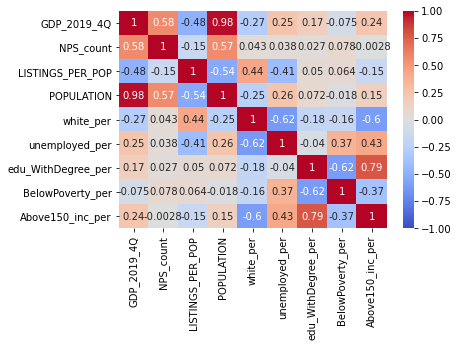

In [298]:
# checking correlation of the variables:

import seaborn as sns

sns.heatmap(
    NPS_census.corr(), 
    cmap="coolwarm", 
    annot=True, 
    vmin=-1, 
    vmax=1
)

# Unemployment is correlated with poverty, and degrees are correlated with high income.

# now to create an altair version of this plot

In [299]:
#plotting the same heatmap using altair:

import altair as alt
import numpy as np
import pandas as pd

cor_data = (NPS_census.drop(columns=['NAME'])
              .corr().stack()
              .reset_index()     # The stacking results in an index on the correlation values, we need the index as normal columns for Altair
              .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
cor_data['correlation_label'] = cor_data['correlation'].map('{:.2f}'.format)  # Round to 2 decimal

In [325]:
import pandas as pd
alt.data_transformers.disable_max_rows()

base = alt.Chart(cor_data).encode(
    alt.X('variable2:O', title=None),
    alt.Y('variable:O', title=None))

# Text layer with correlation labels
# Colors are for easier readability
text = base.mark_text().encode(
    text='correlation_label',
    color=alt.condition(
        alt.datum.correlation > 0.5, 
        alt.value('white'),
        alt.value('black')
    )
)

# The correlation heatmap itself
cor_plot = base.mark_rect().encode(
    color= alt.Color('correlation:Q', scale=alt.Scale(scheme='greenblue'))
).properties(
    width=400,
    height=400
)

heatmap = cor_plot + text # The '+' means overlaying the text and rect layer

heatmap

alt.LayerChart(...)

In [328]:
heatmap.save("C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/heatmap_culsters.json")

In [329]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)
%matplotlib inline

In [330]:
plt.rcParams['figure.figsize'] = (10,6)

In [331]:
#Non-spatial clustering

import altair as alt
from vega_datasets import data as vega_data

In [332]:
alt.Chart(NPS_census).mark_circle().encode(
    alt.X("white_per:Q", scale=alt.Scale(type="log")),
    alt.Y("LISTINGS_PER_POP:Q", scale=alt.Scale(zero=False)),
    size='LISTINGS_PER_POP:Q',
    #tooltip=list(gapminder.columns),
).interactive()

alt.Chart(...)

In [333]:
# K-Means with scikit-learn
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)


In [334]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [335]:
#Use the fit_transform() function to scale your features

NPS_census_scaled = scaler.fit_transform(NPS_census[['LISTINGS_PER_POP','GDP_2019_4Q','white_per','BelowPoverty_per','Above150_inc_per']])

In [336]:
# Perform the fit
kmeans.fit(NPS_census_scaled)

# Extract the labels
NPS_census['label'] = kmeans.labels_

C:\Users\ililf\miniconda3\envs\musa-550-fall-2020\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [337]:
alt.Chart(NPS_census).mark_circle().encode(
    alt.X("GDP_2019_4Q:Q", scale=alt.Scale(type="log")),
    alt.Y("LISTINGS_PER_POP:Q", scale=alt.Scale(zero=False)),
    size='LISTINGS_PER_POP:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='greenblue')),
    #tooltip=list(gapminder.columns),
).interactive()

alt.Chart(...)

In [338]:
# non interactive chart for the web:

plot1_clusters = alt.Chart(NPS_census).mark_circle().encode(
    alt.X("GDP_2019_4Q:Q", scale=alt.Scale(type="log")),
    alt.Y("LISTINGS_PER_POP:Q", scale=alt.Scale(zero=False)),
    size='LISTINGS_PER_POP:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='greenblue')),
    #tooltip=list(gapminder.columns),
)

plot1_clusters.save("C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/plot1_clusters.json")

In [339]:
# Number of states per cluster
NPS_census.groupby("label").size()

label
0     3
1    18
2    17
3     1
4    12
dtype: int64

In [340]:
#testing to plot that:
df2 = NPS_census.groupby("label").size()
table2 = df2.hvplot.table(sortable=True, selectable=True)
hvplot.save(table2, "C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/table2_dist.html")

In [341]:
NPS_census.loc[NPS_census['label']==3] 

,NAME,GDP_2019_4Q,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,label
7,DISTRICT OF COLUMBIA,145278,480,0.000701,684498,43.251697,5.123719,56.201608,14.890104,43.211572,3


In [342]:
NPS_census.loc[NPS_census['label']==0] 

,NAME,GDP_2019_4Q,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,label
10,NEW YORK,1791567,4481,0.000228,19618453,66.134960,3.777809,43.542552,11.995018,19.973243,0
39,TEXAS,1861582,2514,0.000090,27885195,76.563506,3.472945,35.125694,11.513685,14.131689,0
46,CALIFORNIA,3205000,2100,0.000054,39148760,64.098053,4.247947,40.432438,11.100624,20.477893,0


In [343]:
# plotting the clusters on a map:

year = 2018
resolution = 20

states = gpd.read_file(f"https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_{year}_us_state_{resolution}m.zip")
states = states[["NAME","geometry"]]
states['NAME'] = states['NAME'].str.upper() 
states = states.to_crs(epsg=3857)

NPS_census_states = states.merge(
    NPS_census,
    left_on=["NAME"],
    right_on=["NAME"],
)

len(NPS_census_states)

51

In [344]:
import altair as alt
from vega_datasets import data

# IMPORTANT: Altair needs the GeoDataFrame to be in EPSG:4326
states_4326 = NPS_census_states.to_crs(epsg=4326)

# plot map, where variables ares nested within `properties`,
alt.Chart(states_4326).mark_geoshape(stroke="white").encode(
    tooltip=["NAME:N","NPS_count:Q","LISTINGS_PER_POP:Q"],
    color=alt.Color("label:N", legend=alt.Legend(title="5 clusters"), scale=alt.Scale(scheme="greenblue")),
).properties(
    title='Kmeans, 5 clusters',
    width=650,
    height=400
).project('albersUsa')


alt.Chart(...)

In [345]:
map1 = alt.Chart(states_4326).mark_geoshape(stroke="white").encode(
    #tooltip=["NAME:N","NPS_count:Q","LISTINGS_PER_POP:Q"],
    color=alt.Color("label:N", legend=alt.Legend(title="5 clusters"), scale=alt.Scale(scheme="greenblue")),
).properties(
    title='Kmeans, 5 clusters',
    width=650,
    height=400
).project('albersUsa')

map1.save("C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/map1_clusters.json")

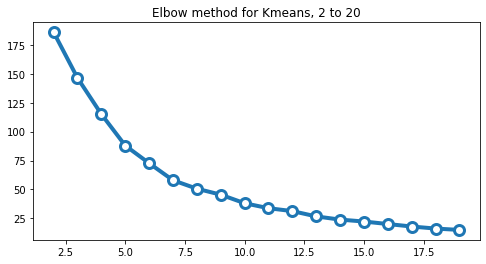

In [352]:
import pandas as pd
import altair as alt
from vega_datasets import data as vega_data
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Number of clusters to try out
n_clusters = list(range(2, 20))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:

    # Initialize and run
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(NPS_census_scaled)

    # Save the "inertia"
    inertias.append(kmeans.inertia_)

# Plot it!
plt.figure(figsize=(8, 4))
plt.title('Elbow method for Kmeans, 2 to 20')
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3)

plt.savefig('C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/elbow.png', dpi=600, bbox_inches='tight')

In [356]:
# package called kneed that can determine the "knee" point quantitatively, using the kneedle algorithm.

from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

7


In [357]:
# since the package provided 7, we will use that on our clusters code and re-print the graph:

In [358]:
kmeans = KMeans(n_clusters=7)

# Perform the fit
kmeans.fit(NPS_census_scaled)

# Extract the labels
NPS_census['label'] = kmeans.labels_

import altair as alt
from vega_datasets import data

In [361]:
NPS_census_states = states.merge(
    NPS_census,
    left_on=["NAME"],
    right_on=["NAME"],
)

# IMPORTANT: Altair needs the GeoDataFrame to be in EPSG:4326
states_4326 = NPS_census_states.to_crs(epsg=4326)

# plot map, where variables ares nested within `properties`,
map2 = alt.Chart(states_4326).mark_geoshape(stroke="white").encode(
    tooltip=["NAME:N","NPS_count:Q","LISTINGS_PER_POP:Q"],
    color=alt.Color("label:N", legend=alt.Legend(title="7 clusters"), scale=alt.Scale(scheme="greenblue")),
).properties(
    title='Kmeans, 7 clusters',
    width=650,
    height=400
).project('albersUsa')

map2.save("C:/Users/ililf/Dropbox/Fall_2020/MUSA_550_NICK/final_musa/map2_clusters.json")

map2

alt.Chart(...)

In [360]:
# Number of states per cluster
NPS_census.groupby("label").size()

label
0    13
1     8
2     6
3     3
4     4
5    16
6     1
dtype: int64